In [20]:
import torch as th
import numpy as np

In [50]:
### Scheduler: To control the rate of noise additon

# Noise gaussian stats -> mean=sqrt(1 - beta), variance=beta
def linear_beta_schedule(t):
    scale = 1
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return th.linspace(beta_start, beta_end, t) 

In [51]:
T = 300 # number of timesteps

betas = linear_beta_schedule(T)

alphas = 1 - betas
alpha_prod = th.cumprod(alphas, 0)
alpha_prod_prev = th.cat([th.tensor([1.0]), alpha_prod[:-1]])

# alpha_prod_sqrt = th.sqrt(alpha_prod)
posterior_var =  betas * (1. - alpha_prod_prev) / (1. - alpha_prod)

def get_noisy_image(x_0, alphas, t):
    alpha_prod = th.cumprod(alphas, 0)
    noise = th.randn_like(x_0)

    alpha_prod_t = alpha_prod[t]
    alpha_prod_prev_t = alpha_prod_prev[t]

    x_t = th.sqrt(alpha_prod_t) * x_0 + th.sqrt(1 - alpha_prod_t) * noise
    return x_t

### DIffusion process

In [52]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
img = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC
# image

# Convert PIL image to a torch tensor
from torchvision import transforms

# convenience functions
def image_to_tensor(image, image_size=256):
    transform_to_tensor = transforms.Compose([
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    image_tensor = transform_to_tensor(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Convert torch tensor to RGB image
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.permute(1, 2, 0)  # Reshape tensor to HWC
    tensor = tensor.clamp(0, 1)  # Clamp values to be between 0 and 1
    return tensor.numpy()  # Convert tensor to numpy array



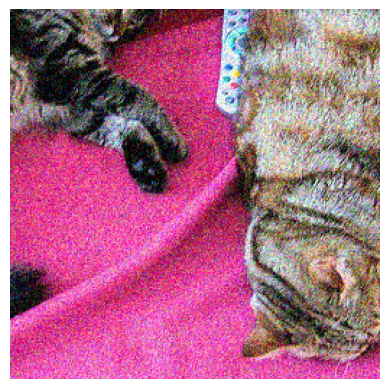

In [53]:
import matplotlib.pyplot as plt

img= image_to_tensor(img)
img = get_noisy_image(img, alphas, t=20)
    
# Plot the noisy image
img = tensor_to_image(img)
plt.imshow(img)
plt.axis('off')
plt.show()

## Loss function

In [54]:
import torch.nn.functional as F

def loss_fn(predicted_img, actual_noise):
    return F.mse_loss(noise, predicted_noise)


## Sampling a new img

In [60]:
import numpy as np

def p_sample(model_output, x, t, T):

    # safety checks
    B, C = x.shape[:2]

    # assert t.shape == (B,)
    assert model_output.shape == (B, C * 2, *x.shape[2:])

    model_output, model_var_values = th.split(model_output, C, dim=1)

    betas = linear_beta_schedule(T)
    alphas = 1. - betas

    alpha_prod = th.cumprod(alphas, 0)
    alpha_prod_prev = th.cat([th.tensor([1.0]), alpha_prod[:-1]])
    posterior_var =  betas * (1. - alpha_prod_prev) / (1. - alpha_prod)

    # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
    if len(posterior_var) > 1:
        posterior_var = th.log(th.cat([posterior_var[1].unsqueeze(0), posterior_var[1:]]))
    else:
        posterior_var = th.tensor([])

    # extract values for given timestep
    alpha_prod  = alphas[t]
    alpha_prod_prev= alphas[t-1]
    
    # mean prediction
    # noise_pred = model(x, t, model_kwargs)     
    noise_pred = model_output
    mean_pred =  (x - (betas[t] * noise_pred / th.sqrt(1. - alpha_prod))) * 1 / th.sqrt(alphas[t])

    # var prediction
    # var_fixed = betas[t] * th.eye(x.size(0)) 
    min_log = posterior_var[t]
    max_log = th.log(betas[t])

    # The model_var_values is [-1, 1] for [min_var, max_var].
    frac = (model_var_values + 1) / 2
    model_log_variance = frac * max_log + (1 - frac) * min_log
    var_pred = th.exp(model_log_variance)

    x_prev = mean_pred + var_pred
    return x_prev 


In [56]:
z = th.randn(2,4,32,32)
n_sampling_steps = 5

# start with pure noise
x = th.randn_like(z)  
print("x: ", x.shape)

# time indices in reverse
indices = list(range(1, n_sampling_steps +1))[::-1]

for i in indices:
    t = th.tensor([i] * x.shape[0], device="cpu") 

    #model_output = model.forward_with_cfg(x, t, y, cfg_scale)
    model_output = th.randn(2,8,32,32)

    x = p_sample(model_output, x, i, n_sampling_steps) 

print("X: ", x[0,0,:50,:50])

x:  torch.Size([2, 4, 32, 32])
X:  tensor([[ 2.2469, -0.2784,  1.5437,  ...,  1.3850,  0.6858,  0.3382],
        [-0.3110,  1.0056,  2.4272,  ..., -0.8944,  0.1380, -0.2204],
        [-0.2223, -1.4995,  1.6688,  ...,  0.5462,  0.6950,  0.4349],
        ...,
        [ 0.7085, -0.4130,  0.3902,  ...,  0.9263, -0.8547, -1.4288],
        [-1.0819, -0.8462,  1.0942,  ..., -1.2833,  1.0199,  0.8032],
        [-0.4255, -0.0771, -2.3955,  ..., -1.0206, -2.0811,  0.8761]])


In [57]:
z = th.randn(2,4,32,32)
n_sampling_steps = 5

# start with pure noise
x = th.randn_like(z)  # Added batch dimension
print("x: ", x.shape)

# time indices in reverse
indices = list(range(1, n_sampling_steps+1))[::-1]

x_new = []

for i in indices:
    t = th.tensor([i] * x.shape[0], device="cpu") 

    # model_output = model.forward_with_cfg(x, t, y, cfg_scale)
    model_output = th.randn(2,8,32,32)
    
    x_new = th.stack([p_sample(model_output, x, ti, n_sampling_steps) for ti in t])

x:  torch.Size([2, 4, 32, 32])


## Spaced diffusion from original implementation

In [67]:
from diffusion.respace import SpacedDiffusion, space_timesteps
import diffusion.gaussian_diffusion as gd

def linear_beta_schedule_np(num_diffusion_timesteps):
    scale = 1000  / num_diffusion_timesteps 
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return np.linspace(beta_start, beta_end, num_diffusion_timesteps) 

n_sampling_steps = 5
diffusion_steps=1000
betas = linear_beta_schedule_np(diffusion_steps)

spaced_diffusion = SpacedDiffusion(
use_timesteps=space_timesteps(diffusion_steps,[n_sampling_steps]),
betas=betas,
model_mean_type=gd.ModelMeanType.EPSILON,
model_var_type=gd.ModelVarType.LEARNED_RANGE,
loss_type = gd.LossType.MSE)



In [64]:
z = th.randn(2,4,32,32)

# start with pure noise
x = th.randn_like(z)  
print("x: ", x.shape)

# time indices in reverse
# indices = list(range(1, n_sampling_steps +1))[::-1]
indices = list(range(spaced_diffusion.num_timesteps))[::-1]

for i in indices:
    t = th.tensor([i] * x.shape[0], device="cpu") 

    #model_output = model.forward_with_cfg(x, t, y, cfg_scale)
    model_output = th.randn(2,8,32,32)

    x = p_sample(model_output, x, i, spaced_diffusion.num_timesteps) 

print("X: ", x[0,0,:50,:50])

x:  torch.Size([2, 4, 32, 32])
X:  tensor([[ 2.7362, -0.4610, -1.7339,  ..., -0.4998,  0.1897,  0.0805],
        [ 0.4227, -0.1097,  0.0098,  ..., -0.7200, -0.9452,  1.7633],
        [ 0.6956, -1.9089, -1.8087,  ...,  0.8141,  1.4082, -1.6835],
        ...,
        [ 0.5615,  0.4217,  0.8122,  ..., -1.0163,  0.6786, -0.1390],
        [ 1.9527,  1.0496,  1.8949,  ...,  0.1506,  0.5266, -0.2562],
        [-0.1018, -1.2019,  0.6161,  ..., -0.8719,  0.3293, -1.3064]])


In [69]:
spaced_diffusion.betas

array([1.00000000e-04, 4.78524822e-01, 8.50799344e-01, 9.56931949e-01,
       9.87954726e-01])